## Outline

To specify a simulation, one needs to provide:

* total simulation time `total_time`  
* simulations start and end times `stim_start` and `stim_end`
* reward function evaluation time `eval_time`
* a reward function `reward_func` mapping rates to a reward variable
* (optional) a reward derivative `dR_dt`
* (for plasticity) `weight_plasticity_parameters` for the plasticity rule
* (for repeated trials) the starting weight matrix `W`

## TODO:

1. run simulations in parallel to see which ranges of `w_plus` and `w_minus` are stable.

### Testing [simulation.py](./simulation.py) Below

TODO:  

* serialise and use map for a gridsearch to find stable behaviour
* implement EA with `weight_plasticity_params`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from simulation import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
## everything becomes NaNs
W_new = get_weights()
theta = None
for i in tqdm(range(6)):
    coherence = np.random.choice([-0.7, 0.7])
    times,\
    nu_tracked,\
    s_NMDA_tracked,\
    s_AMPA_tracked,\
    s_GABA_tracked,\
    I_syn_tracked,\
    theta_tracked,\
    e_tracked,\
    W_tracked = run_trial_coherence_2afc(
        total_time=2*runtime,
        coherence=coherence,
        theta=theta,
        W=W_new
    ).values()
    if np.any(np.isnan(W_tracked)):
        print(f'Encountered NaNs on iteration {i}')
        break
    W_new = W_tracked[:,:,-1].copy()
    theta = theta_tracked[:, -1].copy()

100%|██████████| 6/6 [03:16<00:00, 32.73s/it]


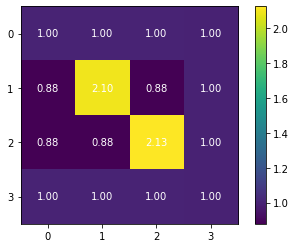

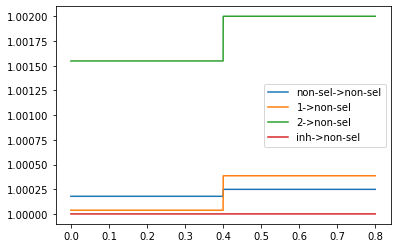

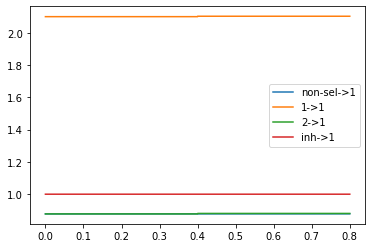

In [4]:
plt.figure()

is_nan = np.any(np.isnan(W_tracked), axis=(0, 1))
first_nan = is_nan.argmax() if is_nan.max() else W_tracked.shape[-1]
plt.imshow(W_tracked[:,:,first_nan-1])
plt.colorbar()
for i in range(p+2):
    for j in range(p+2):
        plt.text(j, i, f"{W_tracked[i,j,first_nan-1]:.2f}",
                       ha="center", va="center", color="w")

plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.figure()
# plt.plot(times, np.max(W_tracked, axis=(0, 1)), label='max')
# plt.plot(times, np.min(W_tracked, axis=(0, 1)), label='min')
weight_lines = plt.plot(times, W_tracked[0, :, :].T)
plt.legend(
    weight_lines,
    [f'{k}->non-sel' for k in ['non-sel']+list(range(1,p+1))+['inh'] ],
#     title='neuron population',
)

sel_n = 1
plt.figure()
weight_lines = plt.plot(times, W_tracked[sel_n, :, :].T)
plt.legend(
    weight_lines,
    [f'{k}->{sel_n}' for k in ['non-sel']+list(range(1,p+1))+['inh'] ],
#     title='neuron population',
)
plt.show()

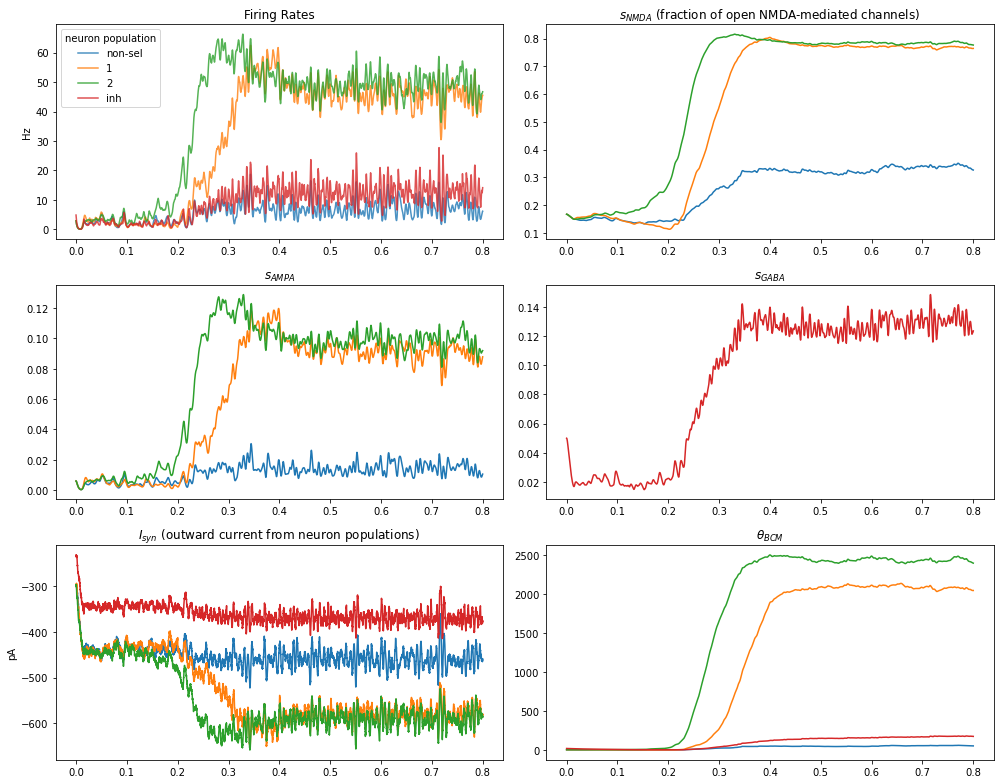

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(14,11))

# clear_output(wait=True)
rates_lines = axes[0][0].plot(
    times, nu_tracked.T,
    alpha=0.8
)
axes[0][0].legend(
    rates_lines,
    ['non-sel'] + list(range(1, p+1)) +  ['inh'],
    title='neuron population',
)
# _, ymax = axes[0][0].get_ylim()
# axes[0][0].set_ylim([0., min(40., ymax)])

axes[0][0].set_ylabel('Hz')
axes[0][0].set_title('Firing Rates')
axes[0][1].plot(times, s_NMDA_tracked[pyramidal_mask, :].T)
axes[0][1].set_title('$s_{NMDA}$ (fraction of open NMDA-mediated channels)')
axes[1][0].plot(times, s_AMPA_tracked[pyramidal_mask, :].T)
axes[1][0].set_title('$s_{AMPA}$')
axes[1][1].plot(times, s_GABA_tracked[~pyramidal_mask, :].T, color=rates_lines[-1].get_color())
axes[1][1].set_title('$s_{GABA}$')
axes[2][0].plot(times, I_syn_tracked.T * 1e12)
axes[2][0].set_ylabel('pA')
axes[2][0].set_title('$I_{syn}$ (outward current from neuron populations)')
axes[2][1].plot(times, theta_tracked.T)
axes[2][1].set_title(r'$\theta_{BCM}$')
# axes[2][1].set_ylim([0., 40.])

plt.tight_layout()
plt.show(fig)